# UMAP 기반 데이터 분석 및 시각화

Train/Test 데이터의 임베딩을 생성하고, UMAP으로 차원 축소하여 다양한 시각화를 수행합니다.
- Hard Train/Test 분석
- Dense Test 영역 식별
- Train-like Test 탐지
- Representative Train 선정

## 1. 환경 설정 및 패키지 설치

In [1]:
# 필수 패키지 설치
!pip install -qU umap-learn langchain-community langchain-core langchain-upstage transformers sentence-transformers peft accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# 라이브러리 Import
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import umap.umap_ as umap
from matplotlib.lines import Line2D
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances

%matplotlib inline

패키지 재 설치 후 -> 세션 다시시작

In [3]:
# 한글 폰트 설치 및 설정 (Colab/Linux 환경)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,822 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and dire

설정된 폰트: NanumGothic


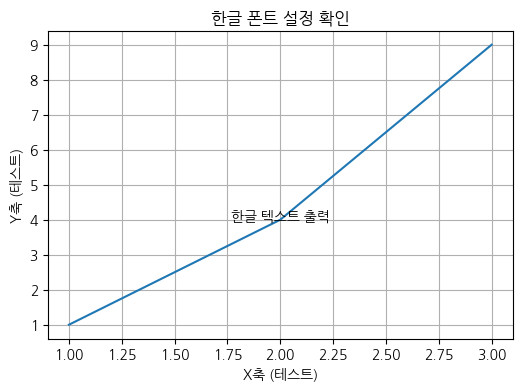

In [1]:
# 한글 폰트 설치 및 설정 (Colab/Linux 환경)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 경로 설정 및 적용
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

print(f"설정된 폰트: {font_name}")

# 한글 폰트 표시 확인을 위한 테스트 그래프
plt.figure(figsize=(6, 4))
plt.plot([1, 2, 3], [1, 4, 9])
plt.title('한글 폰트 설정 확인')
plt.xlabel('X축 (테스트)')
plt.ylabel('Y축 (테스트)')
plt.text(2, 4, '한글 텍스트 출력', ha='center')
plt.grid(True)
plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 데이터 로드 및 전처리

In [5]:
# 데이터 로드
DATA_PATH = '/content/drive/MyDrive/data'

df_test = pd.read_csv(f'{DATA_PATH}/test.csv')
df_train = pd.read_csv(f'{DATA_PATH}/train.csv')
df_all = pd.read_csv(f'{DATA_PATH}/df_all.csv')
df_hard = pd.read_csv(f'{DATA_PATH}/completed_filtered_train.csv')

print(f"Train: {len(df_train)}, Test: {len(df_test)}, All: {len(df_all)}")

Train: 2031, Test: 869, All: 2900


In [6]:
# problems 컬럼 파싱
df_all['problems'] = df_all['problems'].apply(ast.literal_eval)
df_all['question'] = df_all['problems'].apply(
    lambda x: x.get('question', '') if isinstance(x, dict) else ''
)
df_all['choices'] = df_all['problems'].apply(
    lambda x: x.get('choices', []) if isinstance(x, dict) else []
)

In [7]:
# 전체 텍스트 생성 (제시문 + 보기 + 질문)
def format_question_plus(x):
    if pd.isna(x) or str(x).strip() == "":
        return ""
    return "\n\n<보기>\n" + str(x)

df_all['full_text'] = (
    "<제시문>\n" + df_all['paragraph'].astype(str) +
    df_all['question_plus'].apply(format_question_plus) +
    "\n\n<질문>\n" + df_all['question'].astype(str)
)

print("전체 텍스트 생성 완료")

전체 텍스트 생성 완료


In [8]:
# Hard 문제 마스크 생성
df_train['hard'] = df_train['id'].isin(df_hard['id'])

# Difficult Test 리스트
list_difficult = [
    10, 11, 16, 23, 31, 33, 38, 39, 40, 41, 42, 44, 45, 50, 54, 58, 60, 71, 72, 78,
    79, 82, 84, 86, 92, 96, 101, 115, 119, 121, 130, 140, 141, 154, 157, 160, 161, 162,
    163, 165, 166, 170, 172, 176, 179, 181, 195, 196, 204, 205, 211, 212, 213, 214, 216,
    218, 225, 226, 227, 229, 235, 237, 242, 252, 257, 266, 267, 268, 269, 272, 273, 276,
    278, 281, 283, 287, 294, 295, 296, 298, 307, 308, 311, 313, 315, 318, 322, 324, 338,
    339, 344, 346, 351, 352, 353, 356, 357, 360, 364, 365, 369, 371, 372, 379, 381, 384,
    389, 395, 402, 406, 407, 411, 414, 417, 423, 424, 439, 465, 470, 472, 479, 483, 500,
    514, 519, 521, 522, 533, 536, 543, 550, 562, 611, 624, 625, 643, 651, 664, 700, 701,
    704, 718, 724, 740, 756, 767, 775, 777, 783, 791, 828, 843
]

print(f"Hard Train: {df_train['hard'].sum()}, Difficult Test: {len(list_difficult)}")

Hard Train: 239, Difficult Test: 152


## 3. 임베딩 생성

In [9]:
# 임베딩 모델 로드
model = SentenceTransformer("dragonkue/BGE-m3-ko", trust_remote_code=True)
print(f"모델 로드 완료: {model}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

모델 로드 완료: SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False, 'architecture': 'XLMRobertaModel'})
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [10]:
# Train/Test 임베딩 생성
def build_train_test_embeddings(df_all, df_train, model, text_col="full_text"):
    """Train/Test 임베딩 생성"""
    train_len = len(df_train)
    train_text = df_all.iloc[:train_len][text_col].tolist()
    test_text = df_all.iloc[train_len:][text_col].tolist()

    X_train_emb = model.encode(train_text, show_progress_bar=True)
    X_test_emb = model.encode(test_text, show_progress_bar=True)

    return X_train_emb, X_test_emb

X_train_emb, X_test_emb = build_train_test_embeddings(df_all, df_train, model)
print(f"임베딩 shape - Train: {X_train_emb.shape}, Test: {X_test_emb.shape}")

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

임베딩 shape - Train: (2031, 1024), Test: (869, 1024)


## 4. 유틸리티 함수 정의

In [11]:
# Category 색상 팔레트
CATEGORY_PALETTE = {
    "한국사": "#1f77b4", "책마을": "#ff7f0e", "정치": "#2ca02c", "역사": "#d62728",
    "경제": "#9467bd", "사회": "#8c564b", "국제": "#e377c2", "지리": "#7f7f7f",
    "심리": "#bcbd22", "교육산업": "#17becf", "생활": "#aec7e8", "부동산": "#ffbb78",
}

def apply_umap_reduction(X_train_emb, X_test_emb, n_components=2,
                         n_neighbors=15, min_dist=0.1, random_state=42):
    """UMAP 차원 축소"""
    train_len = len(X_train_emb)
    combined_embeddings = np.vstack([X_train_emb, X_test_emb])

    reducer = umap.UMAP(
        n_components=n_components, n_neighbors=n_neighbors,
        min_dist=min_dist, metric="cosine", random_state=random_state
    )

    reduced_2d = reducer.fit_transform(combined_embeddings)
    return reduced_2d[:train_len], reduced_2d[train_len:]

## 5. UMAP 차원 축소 실행

In [12]:
# UMAP 차원 축소
train_2d, test_2d = apply_umap_reduction(X_train_emb, X_test_emb)
train_len = len(df_train)
print(f"축소 완료 - Train: {train_2d.shape}, Test: {test_2d.shape}")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


축소 완료 - Train: (2031, 2), Test: (869, 2)


## 6. Dense Test 영역 탐지 (kNN 기반)

In [13]:
# Dense Test 영역 탐지 (Test끼리 밀집된 영역)
k = 20
nbrs_2d = NearestNeighbors(n_neighbors=k).fit(np.vstack([train_2d, test_2d]))
_, nn_idx = nbrs_2d.kneighbors(test_2d)

is_test = np.array([0]*train_len + [1]*len(test_2d))

test_dominant_mask = []
for neigh in nn_idx:
    test_ratio = is_test[neigh].mean()
    test_dominant_mask.append(test_ratio > 0.7)

test_dominant_mask = np.array(test_dominant_mask)
dense_test_df = df_all.iloc[train_len:].iloc[test_dominant_mask]
print(f"Dense Test 샘플 수: {len(dense_test_df)}")

Dense Test 샘플 수: 358


In [14]:
# 우상단 영역 추가 (보정)
upper_right_mask = (test_2d[:, 0] > 7) & (test_2d[:, 1] > 2)
dense_test_mask_v2 = test_dominant_mask | upper_right_mask

print(f"기존 dense: {test_dominant_mask.sum()}")
print(f"우상단 추가: {upper_right_mask.sum()}")
print(f"최종 dense: {dense_test_mask_v2.sum()}")

기존 dense: 358
우상단 추가: 115
최종 dense: 395


In [15]:
# Dense Test 데이터프레임 생성
dense_test_df_v2 = df_all.iloc[train_len:].iloc[dense_test_mask_v2].reset_index(drop=True)
dense_test_df_v2.head()

,id,paragraph,problems,question_plus,category,question,choices,full_text
0,generation-for-nlp-0,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다 . 독서의 즐거움에는 ...,"{'question': '윗글의 내용과 일치하지 않는 것은?', 'choices'...",NaN,NaN,윗글의 내용과 일치하지 않는 것은?,"[같은 책을 읽은 독자라도 서로 다른 의미를 구성할 수 있다 ., 다른 독자와의 소...",<제시문>\n사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다 . 독서의...
1,generation-for-nlp-1,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다 . 독서의 즐거움에는 ...,{'question': '윗글을 읽고 ㉠에 대해 보인 반응으로 적절하지 않은 것은...,NaN,NaN,윗글을 읽고 ㉠에 대해 보인 반응으로 적절하지 않은 것은?,"[오프라인뿐 아니라 온라인 공간에서 해석을 나누는 과정에서도 경험할 수 있겠군.,...",<제시문>\n사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다 . 독서의...
2,generation-for-nlp-2,(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집하고 항목별로...,"{'question': '(가 )와 (나 )에 대한 설명으로 가장 적절한 것은?',...",NaN,NaN,(가 )와 (나 )에 대한 설명으로 가장 적절한 것은?,"[(가 )는 유서의 유형을 분류하였고 , (나 )는 유서의 분류 기준과 적절성...",<제시문>\n(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집...
3,generation-for-nlp-3,(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집하고 항목별로...,"{'question': '[A ]에 대한 이해로 적절하지 않은 것은?', 'cho...",NaN,NaN,[A ]에 대한 이해로 적절하지 않은 것은?,[조선에서 편찬자가 미상인 유서가 많았던 것은 편찬자의 개인적 목적으로 유서를 활...,<제시문>\n(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집...
4,generation-for-nlp-4,(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집하고 항목별로...,"{'question': '㉮에 대한 이해를 바탕으로 ㉠ , ㉡에 대해 파악한 내용...",NaN,NaN,"㉮에 대한 이해를 바탕으로 ㉠ , ㉡에 대해 파악한 내용으로 적절하지 않은 것은?","[지식의 제공이라는 ㉮의 편찬 의도는, ㉠에서 지식을 심화하고 확장하여 소개한...",<제시문>\n(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집...


## 7. Hard-like Train 선정 (Hard Test 기준)

In [16]:
# Hard Test와 가장 가까운 Train 선정 (cosine distance 기반)
hard_test_mask = df_test.index.isin(list_difficult)
X_hard_test = X_test_emb[hard_test_mask]

dist = cosine_distances(X_hard_test, X_train_emb)
min_dist_per_train = dist.min(axis=0)

# 하위 13%만 선정
tau = np.percentile(min_dist_per_train, 13)
representative_train_idx = np.where(min_dist_per_train <= tau)[0]
hard_like_train_df = df_train.iloc[representative_train_idx].copy()

print(f"Hard-like Train 샘플 수: {len(hard_like_train_df)}")
hard_like_train_df.head()

Hard-like Train 샘플 수: 264


,id,paragraph,problems,question_plus,category,hard
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,"{'question': '(가) 지역에 대한 설명으로 옳은 것은?', 'choice...",NaN,한국사,True
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...","{'question': '(가) 인물이 추진한 정책으로 옳지 않은 것은?', 'ch...",NaN,한국사,True
6,generation-for-nlp-432,(가)신라의 한강 유역 확보 (나)관산성 전투(다) 백제의 웅진 천도 (라)고구려의...,"{'question': '다음 사건을 시기 순으로 바르게 나열한 것은?', 'cho...",NaN,한국사,True
7,generation-for-nlp-433,"신돈이 (가)을/를 설치하자고 요청하자, …(중략)…이 제 도감이 설치되었다. …(...","{'question': '(가)에 대한 설명으로 옳은 것은?', 'choices':...",NaN,한국사,False
12,generation-for-nlp-439,"(가)가/이 귀산 등에게 말하기를 “세속에도 5계가 있으니, 첫째는 충성으로써 임금...","{'question': '(가) 인물에 대한 설명으로 옳은 것은?', 'choice...",NaN,한국사,True


In [17]:
# Hard 컬럼 제거 및 저장 준비
hard_like_train_df = hard_like_train_df.drop(columns=['hard'], errors='ignore').reset_index(drop=True)
hard_like_train_df.head()

,id,paragraph,problems,question_plus,category
0,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,"{'question': '(가) 지역에 대한 설명으로 옳은 것은?', 'choice...",NaN,한국사
1,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...","{'question': '(가) 인물이 추진한 정책으로 옳지 않은 것은?', 'ch...",NaN,한국사
2,generation-for-nlp-432,(가)신라의 한강 유역 확보 (나)관산성 전투(다) 백제의 웅진 천도 (라)고구려의...,"{'question': '다음 사건을 시기 순으로 바르게 나열한 것은?', 'cho...",NaN,한국사
3,generation-for-nlp-433,"신돈이 (가)을/를 설치하자고 요청하자, …(중략)…이 제 도감이 설치되었다. …(...","{'question': '(가)에 대한 설명으로 옳은 것은?', 'choices':...",NaN,한국사
4,generation-for-nlp-439,"(가)가/이 귀산 등에게 말하기를 “세속에도 5계가 있으니, 첫째는 충성으로써 임금...","{'question': '(가) 인물에 대한 설명으로 옳은 것은?', 'choice...",NaN,한국사


In [18]:
# Hard-like Train 데이터 저장
hard_like_train_df.to_csv(f'{DATA_PATH}/hard_like_train_df.csv', index=False)
print("저장 완료: hard_like_train_df.csv")

저장 완료: hard_like_train_df.csv


In [19]:
# Category 분포 확인
print("Hard-like Train Category 분포:")
hard_like_train_df['category'].value_counts(normalize=True)

Hard-like Train Category 분포:


,proportion
category,
역사,0.257576
부동산,0.219697
정치,0.140152
한국사,0.121212
경제,0.087121
사회,0.053030
책마을,0.034091
국제,0.034091
교육산업,0.030303


## 8. 시각화 - Hard Test vs Hard-like Train

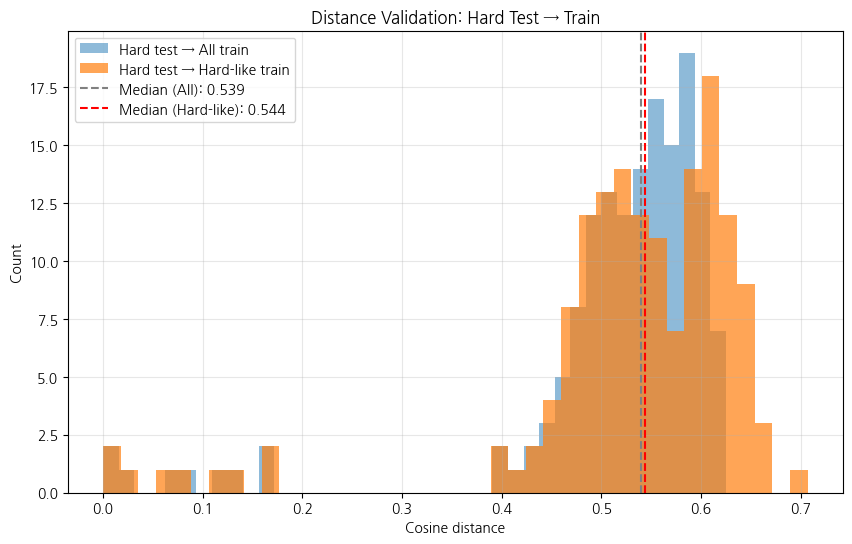

In [20]:
# 거리 분포 검증
dist_all = cosine_distances(X_hard_test, X_train_emb).min(axis=1)
dist_hard_like = cosine_distances(X_hard_test, X_train_emb[representative_train_idx]).min(axis=1)

plt.figure(figsize=(10, 6))
plt.hist(dist_all, bins=40, alpha=0.5, label='Hard test → All train')
plt.hist(dist_hard_like, bins=40, alpha=0.7, label='Hard test → Hard-like train')
plt.axvline(np.median(dist_all), color='gray', linestyle='--', label=f'Median (All): {np.median(dist_all):.3f}')
plt.axvline(np.median(dist_hard_like), color='red', linestyle='--', label=f'Median (Hard-like): {np.median(dist_hard_like):.3f}')
plt.xlabel("Cosine distance")
plt.ylabel("Count")
plt.title("Distance Validation: Hard Test → Train")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [21]:
# UMAP 재실행 (더 조밀한 min_dist)
train_2d_v2, test_2d_v2 = apply_umap_reduction(X_train_emb, X_test_emb, min_dist=0.05)
hard_like_2d = train_2d_v2[representative_train_idx]
print(f"UMAP 재실행 완료 (min_dist=0.05)")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 재실행 완료 (min_dist=0.05)


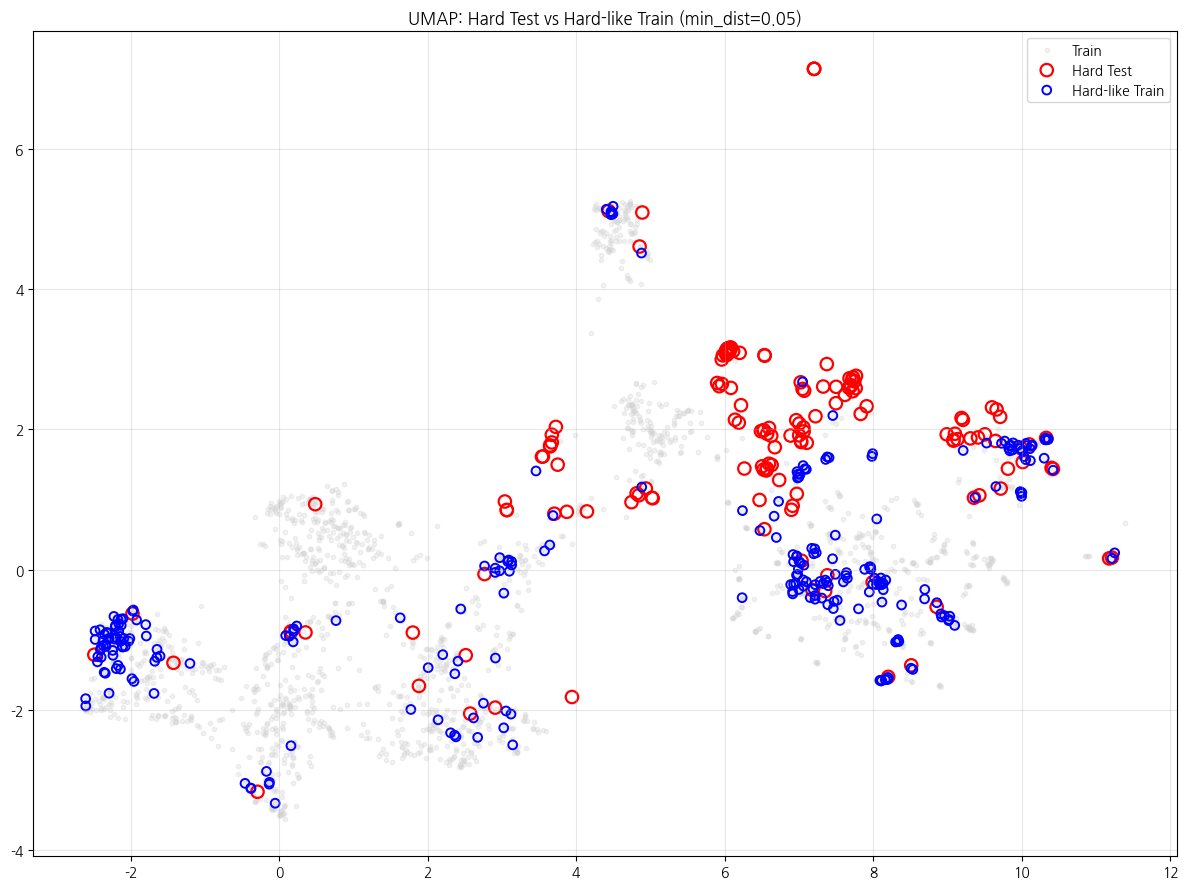

In [22]:
# Hard Test vs Hard-like Train 시각화
plt.figure(figsize=(12, 9))

plt.scatter(train_2d_v2[:,0], train_2d_v2[:,1], c='lightgray', s=10, alpha=0.3, label='Train')
plt.scatter(test_2d_v2[hard_test_mask,0], test_2d_v2[hard_test_mask,1],
            facecolors='none', edgecolors='red', s=80, linewidths=1.6, label='Hard Test')
plt.scatter(hard_like_2d[:,0], hard_like_2d[:,1],
            facecolors='none', edgecolors='blue', s=40, linewidths=1.4, label='Hard-like Train')

plt.legend()
plt.title("UMAP: Hard Test vs Hard-like Train (min_dist=0.05)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Dense Test 저장 및 시각화

In [23]:
# Dense Test 데이터 저장
dense_test_df_v2.to_csv(f'{DATA_PATH}/dense_test_df.csv', index=False)
print("저장 완료: dense_test_df.csv")

저장 완료: dense_test_df.csv


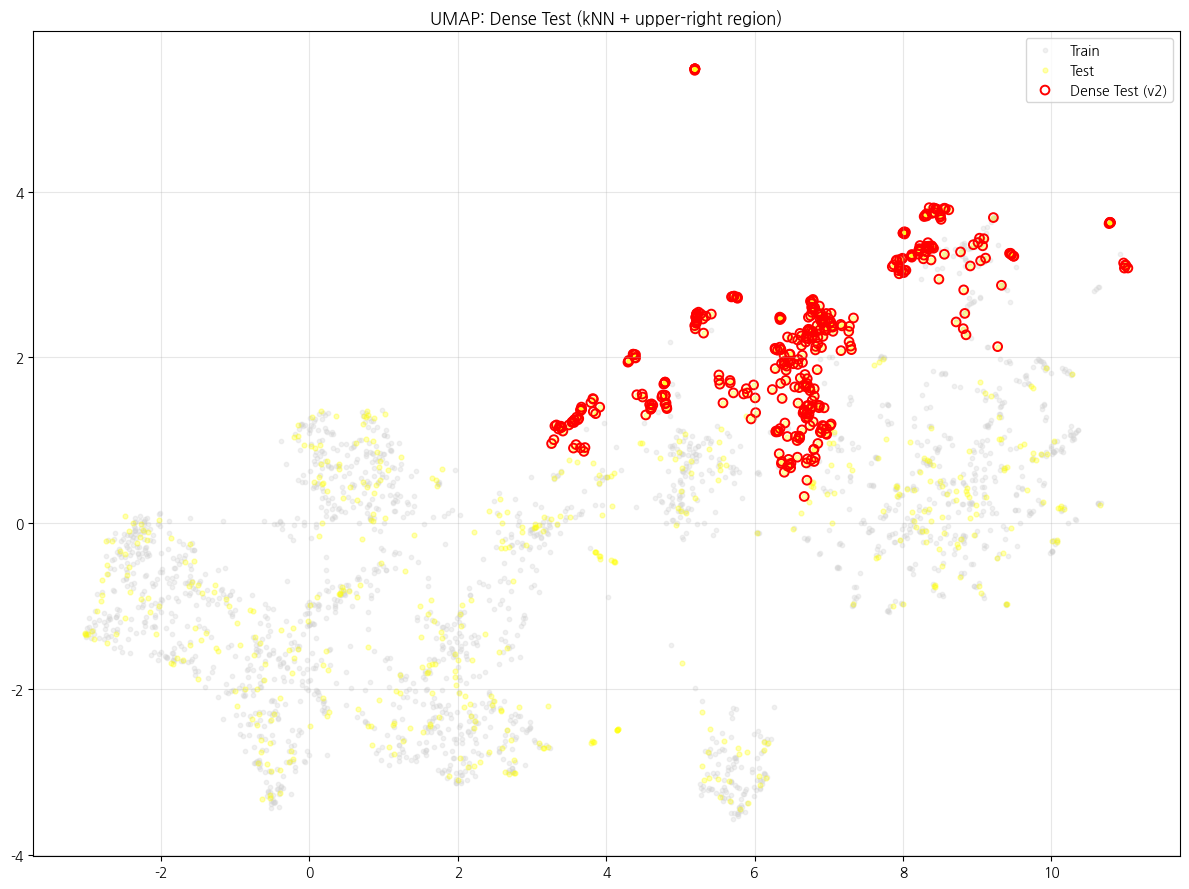

In [24]:
# Dense Test 시각화
plt.figure(figsize=(12, 9))

plt.scatter(train_2d[:,0], train_2d[:,1], c='lightgray', s=10, alpha=0.3, label='Train')
plt.scatter(test_2d[:,0], test_2d[:,1], c='yellow', s=12, alpha=0.3, label='Test')
plt.scatter(test_2d[dense_test_mask_v2, 0], test_2d[dense_test_mask_v2, 1],
            facecolors='none', edgecolors='red', s=40, linewidths=1.4, label='Dense Test (v2)')

plt.legend()
plt.title("UMAP: Dense Test (kNN + upper-right region)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Hard Test vs Dense Test 비교

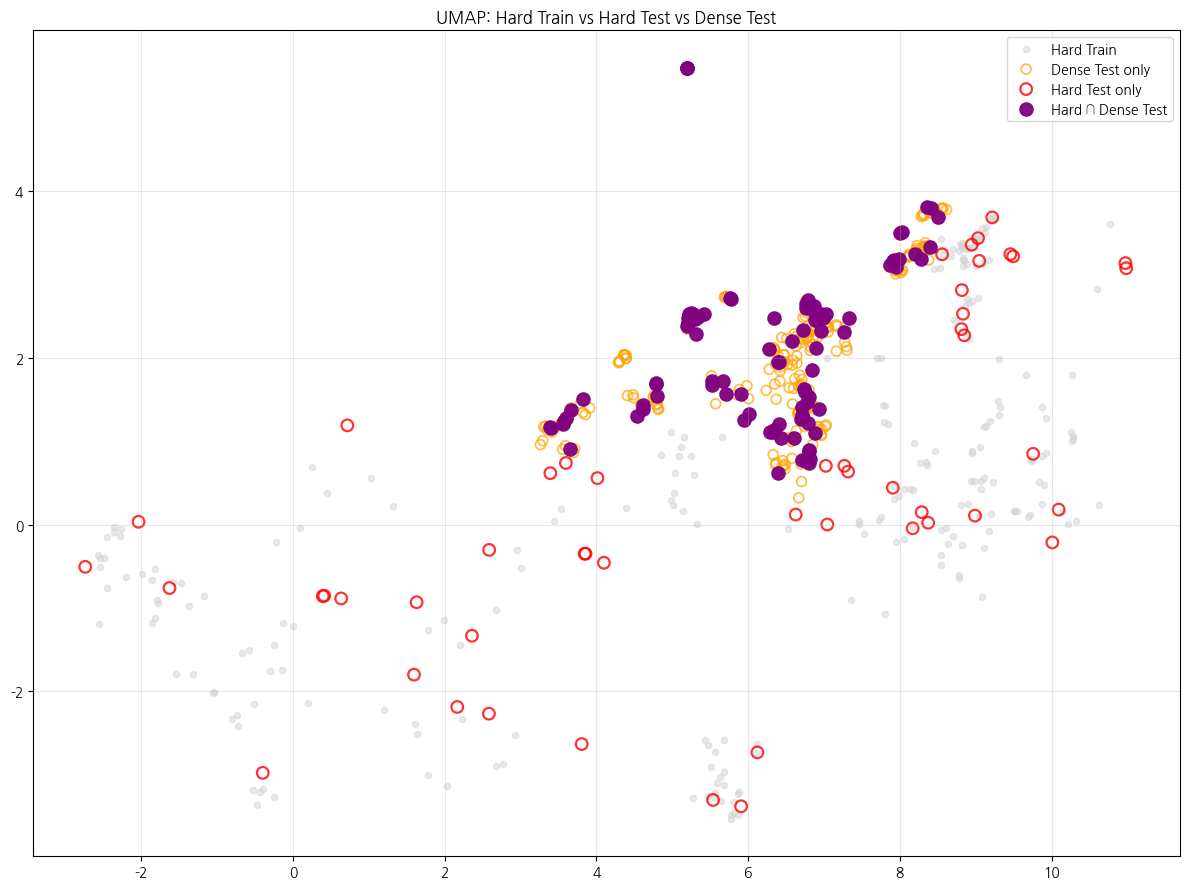

In [25]:
# Hard vs Dense 교집합 분석
hard_test_mask = df_test.index.isin(list_difficult)
dense_test_mask = test_dominant_mask

hard_dense_mask = hard_test_mask & dense_test_mask
hard_only_mask = hard_test_mask & (~dense_test_mask)
dense_only_mask = dense_test_mask & (~hard_test_mask)

plt.figure(figsize=(12, 9))

plt.scatter(train_2d[df_train['hard'], 0], train_2d[df_train['hard'], 1],
            c='lightgray', s=20, alpha=0.5, label='Hard Train')
plt.scatter(test_2d[dense_only_mask, 0], test_2d[dense_only_mask, 1],
            facecolors='none', edgecolors='orange', s=50, linewidths=1.3, alpha=0.7, label='Dense Test only')
plt.scatter(test_2d[hard_only_mask, 0], test_2d[hard_only_mask, 1],
            facecolors='none', edgecolors='red', s=70, linewidths=1.6, alpha=0.8, label='Hard Test only')
plt.scatter(test_2d[hard_dense_mask, 0], test_2d[hard_dense_mask, 1],
            c='purple', s=90, alpha=0.95, label='Hard ∩ Dense Test')

plt.legend()
plt.title("UMAP: Hard Train vs Hard Test vs Dense Test")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Hard Test 기준 kNN Test 탐색

In [26]:
# Hard Test 임베딩 추출
hard_test_mask = df_test.index.isin(list_difficult)
X_hard_test = X_test_emb[hard_test_mask]
print(f"Hard Test 샘플 수: {len(X_hard_test)}")

Hard Test 샘플 수: 152


In [27]:
# Hard Test 주변 Test 샘플 탐색 (kNN)
k = 4
nbrs_test = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(X_test_emb)
distances, nn_idx = nbrs_test.kneighbors(X_hard_test)

# 자기 자신 제외
nn_idx = nn_idx[:, 1:]
similar_test_idx = np.unique(nn_idx.flatten())
print(f"Similar Test 샘플 수: {len(similar_test_idx)}")

Similar Test 샘플 수: 349


In [28]:
# Similar Test 데이터 저장
similar_test_df = df_test.iloc[similar_test_idx].reset_index(drop=True)
similar_test_df.to_csv(f'{DATA_PATH}/df_hard_knn.csv', index=False)
print(f"저장 완료: df_hard_knn.csv ({len(similar_test_df)} 샘플)")

저장 완료: df_hard_knn.csv (349 샘플)


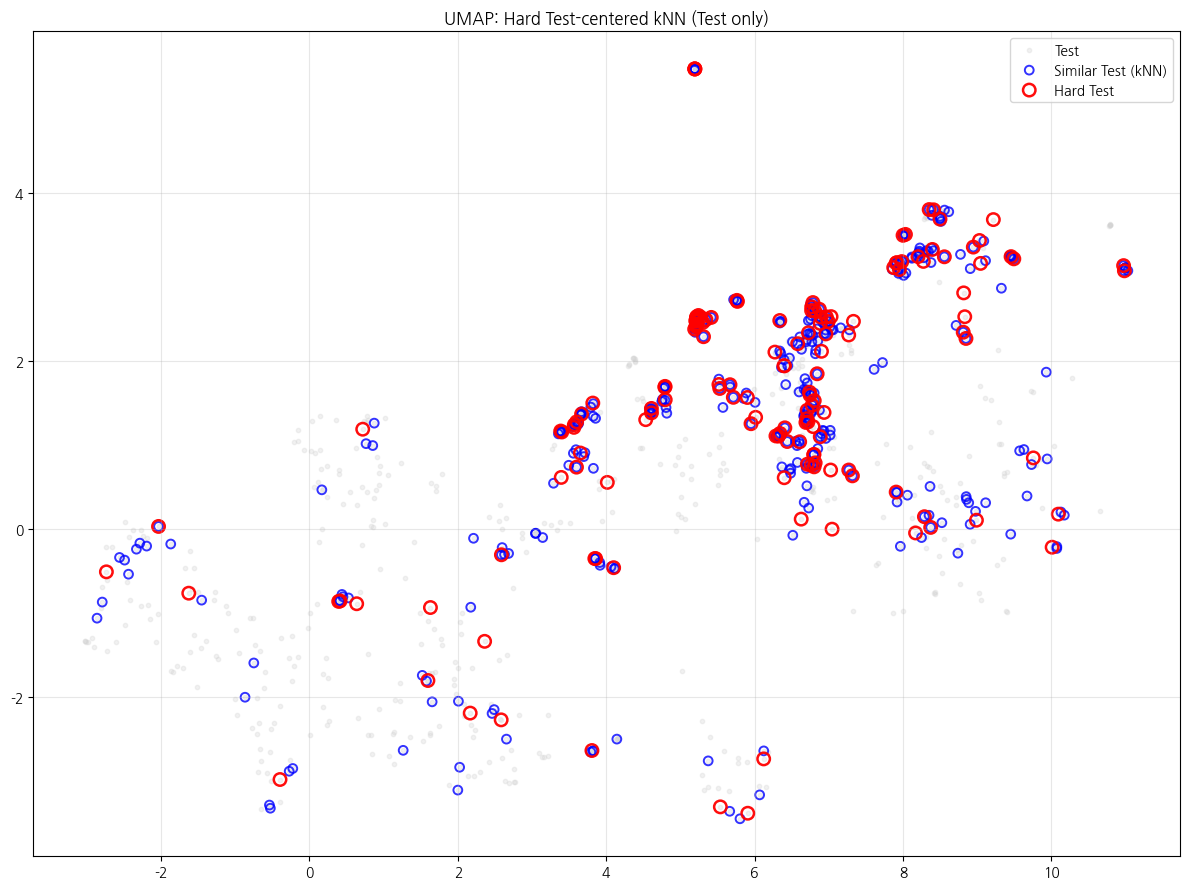

In [29]:
# Similar Test 시각화
plt.figure(figsize=(12, 9))

plt.scatter(test_2d[:, 0], test_2d[:, 1], c='lightgray', s=10, alpha=0.3, label='Test')
plt.scatter(test_2d[similar_test_idx, 0], test_2d[similar_test_idx, 1],
            facecolors='none', edgecolors='blue', s=40, linewidths=1.4, alpha=0.8, label='Similar Test (kNN)')
plt.scatter(test_2d[hard_test_mask, 0], test_2d[hard_test_mask, 1],
            facecolors='none', edgecolors='red', s=80, linewidths=1.8, alpha=0.95, label='Hard Test')

plt.legend()
plt.title("UMAP: Hard Test-centered kNN (Test only)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. OOD Test 저장

In [30]:
# OOD (Out-of-Distribution) Test 저장
dense_test_df = dense_test_df.reset_index(drop=True) if 'dense_test_df' in locals() else dense_test_df_v2
dense_test_df.to_csv(f'{DATA_PATH}/ood_test_df.csv', index=False)
print(f"저장 완료: ood_test_df.csv ({len(dense_test_df)} 샘플)")

저장 완료: ood_test_df.csv (358 샘플)


## 13. 추가 분석 - Train-like Test

In [31]:
# k 값에 따른 test-dominant 샘플 수 확인
for k in [10, 20, 30, 40]:
    nbrs = NearestNeighbors(n_neighbors=k).fit(np.vstack([train_2d, test_2d]))
    _, nn_idx = nbrs.kneighbors(test_2d)

    is_test = np.array([0]*train_len + [1]*len(test_2d))
    mask = [(is_test[neigh].mean() > 0.7) for neigh in nn_idx]
    print(f"k={k}, test-dominant count={np.sum(mask)}")

k=10, test-dominant count=373
k=20, test-dominant count=358
k=30, test-dominant count=351
k=40, test-dominant count=332


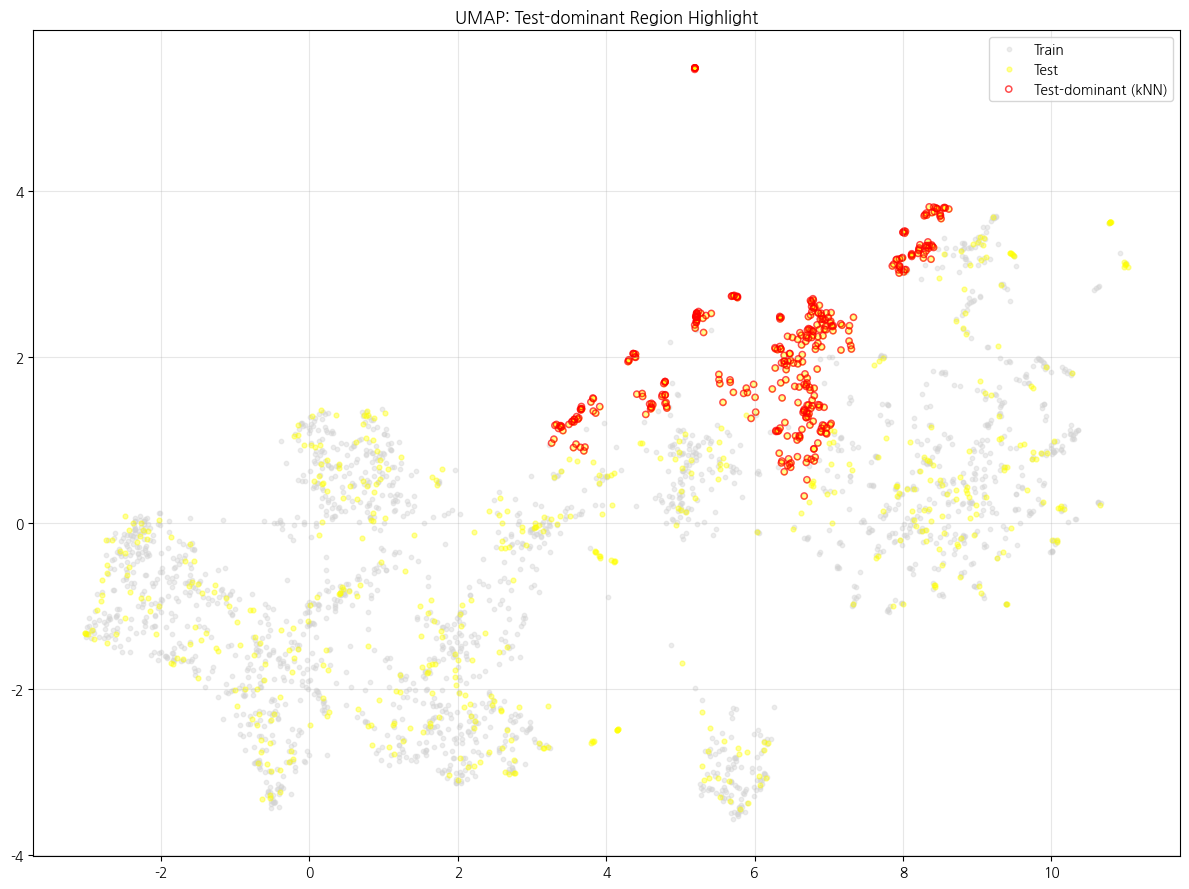

In [32]:
# Test-dominant 영역 시각화
plt.figure(figsize=(12, 9))

plt.scatter(train_2d[:, 0], train_2d[:, 1], c='lightgray', s=10, alpha=0.4, label='Train')
plt.scatter(test_2d[:, 0], test_2d[:, 1], c='yellow', s=12, alpha=0.4, label='Test')
plt.scatter(test_2d[test_dominant_mask, 0], test_2d[test_dominant_mask, 1],
            facecolors='none', edgecolors='red', s=20, linewidths=1.1, alpha=0.7, label='Test-dominant (kNN)')

plt.legend()
plt.title("UMAP: Test-dominant Region Highlight")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 분석 결과
Test-dominant 영역에 속한 샘플들은 Train 데이터와의 최소 cosine distance 중앙값이 약 0.55로, 의미적으로도 Train 분포와 유의미하게 분리되어 있습니다.

In [33]:
# Test-dominant와 Train 간 거리 분석
dist = cosine_distances(X_test_emb[test_dominant_mask], X_train_emb)
min_dist = dist.min(axis=1)
print("Distance percentiles [50%, 75%, 90%]:")
print(np.percentile(min_dist, [50, 75, 90]))

Distance percentiles [50%, 75%, 90%]:
[0.5483067  0.5770366  0.59780418]


## 14. Train-like Test 분석

In [34]:
# Train-like Test 탐지 (Train이 70% 이상인 이웃)
is_train = np.array([1]*train_len + [0]*len(test_2d))
train_dominant_mask = [(is_train[neigh].mean() > 0.7) for neigh in nn_idx]
train_dominant_mask = np.array(train_dominant_mask)
train_like_test_df = df_all.iloc[train_len:].iloc[train_dominant_mask]
print(f"Train-like Test 샘플 수: {len(train_like_test_df)}")

Train-like Test 샘플 수: 407


In [35]:
# Representative Train 선정 (Train-like Test 기준)
k = 21
nbrs = NearestNeighbors(n_neighbors=k, metric="cosine").fit(X_train_emb)
_, train_nn_idx = nbrs.kneighbors(X_test_emb[train_dominant_mask])

train_counts = pd.Series(train_nn_idx.flatten()).value_counts()
representative_train_idx_v2 = train_counts[train_counts >= 3].index
representative_train_df = df_train.iloc[representative_train_idx_v2]
print(f"Representative Train 샘플 수: {len(representative_train_df)}")

Representative Train 샘플 수: 1253


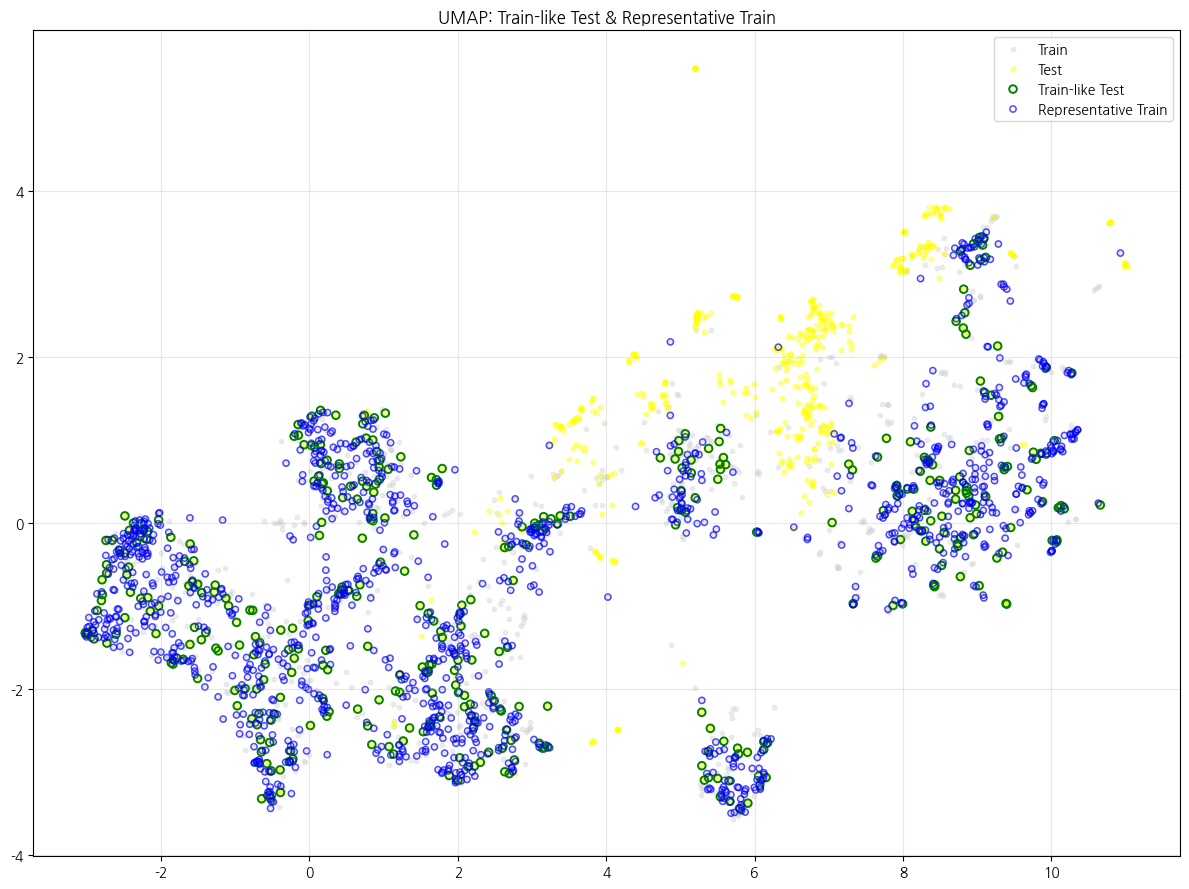

In [36]:
# Train-like Test와 Representative Train 시각화
rep_train_2d = train_2d[representative_train_idx_v2]

plt.figure(figsize=(12, 9))
plt.scatter(train_2d[:, 0], train_2d[:, 1], c='lightgray', s=10, alpha=0.4, label='Train')
plt.scatter(test_2d[:, 0], test_2d[:, 1], c='yellow', s=12, alpha=0.4, label='Test')
plt.scatter(test_2d[train_dominant_mask, 0], test_2d[train_dominant_mask, 1],
            facecolors='none', edgecolors='green', s=30, linewidths=1.4, label='Train-like Test')
plt.scatter(rep_train_2d[:, 0], rep_train_2d[:, 1],
            facecolors='none', edgecolors='blue', s=20, linewidths=1.1, alpha=0.7, label='Representative Train')

plt.legend()
plt.title("UMAP: Train-like Test & Representative Train")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Category 분포 분석

In [37]:
# Representative Train Category 분포
print("Representative Train Category 분포:")
representative_train_df['category'].value_counts(normalize=True)

Representative Train Category 분포:


,proportion
category,
경제,0.252195
역사,0.185156
부동산,0.136472
사회,0.098962
정치,0.086991
교육산업,0.052674
국제,0.047087
생활,0.043097
심리,0.038308


In [38]:
# Representative Train의 Hard 비율 (Category별)
print("Representative Train Hard 비율 (Category별):")
representative_train_df.groupby('category')['hard'].value_counts(normalize=True)

Representative Train Hard 비율 (Category별):


category  hard 
경제        False    0.924051
          True     0.075949
교육산업      False    1.000000
국제        False    1.000000
부동산       False    0.900585
          True     0.099415
사회        False    0.919355
          True     0.080645
생활        False    1.000000
심리        False    0.812500
          True     0.187500
역사        False    0.810345
          True     0.189655
정치        False    0.853211
          True     0.146789
지리        False    1.000000
책마을       False    1.000000
한국사       True     0.600000
          False    0.400000
Name: proportion, dtype: float64

In [39]:
# 전체 Train의 Hard 비율 (Category별) - 비교용
print("전체 Train Hard 비율 (Category별):")
df_train.groupby('category')['hard'].value_counts(normalize=True)

전체 Train Hard 비율 (Category별):


category  hard 
경제        False    0.907080
          True     0.092920
교육산업      False    1.000000
국제        False    1.000000
부동산       False    0.912281
          True     0.087719
사회        False    0.913043
          True     0.086957
생활        False    1.000000
심리        False    0.889706
          True     0.110294
역사        False    0.804094
          True     0.195906
정치        False    0.852632
          True     0.147368
지리        False    1.000000
책마을       False    1.000000
한국사       True     0.602564
          False    0.397436
Name: proportion, dtype: float64

In [40]:
# Train-like Test와 Train 간 거리 검증
dist = cosine_distances(X_test_emb[train_dominant_mask], X_train_emb)
min_dist_train_like = dist.min(axis=1)
print("Train-like Test와 Train 간 거리 percentiles [50%, 75%, 90%]:")
print(np.percentile(min_dist_train_like, [50, 75, 90]))

Train-like Test와 Train 간 거리 percentiles [50%, 75%, 90%]:
[0.45722502 0.51692331 0.56096079]
